# Instead of intro
> Limit order book

- toc: true
- branch: master
- badges: false
- comments: true

Let’s start with some interesting data. The data that has already been downloaded, stored and preprocessed to the form that can be a starting point of further analysis. I selected latest available day for one instrument.

Ladies and gentlemen, let me introduce you to below numpy arrays:
* ```price_matrix``` 
* ```count_matrix```
* ```volume_matrix```
* ```tradebook```
* ```time```

The first glance - shapes and datatypes. Not a surprise - ```time``` is a vector of ```numpy.datetime64```, rest are matrices containing ```floats```. In fact counts and volumes in orderbook might be stored as ```int``` but same format might be convinient in the future. 

It's worth mentioning that one dimension in each array is the same and reflects count of timestamps for the particular day. Another observation is that all arrays could be stored as one matrix or ```pandas.DataFrame``` as maximum ```numpy.ndim``` (after reducing redundant dim) is equal to 2. It's not done for a reason that will become clear when another features will be calculated from abovementioned components.

In [1]:
#hide_input
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import matplotlib.pyplot as plt
import pandas as pd

import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import utils
import json
import numpy as np
from tkinter.filedialog import  askopenfilenames
from utils_data_manipulation import calc_pressure_no_first_place, calc_pressure, calc_volume_levels
import pandas as pd
import datetime as dt
import os.path

import tensorflow as tf

from utils import RepeatedTimer
import sys
from instrument import InstrumentFull

from time import perf_counter_ns

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True, formatter={'float_kind': '{:4.3f}'.format})
np.set_printoptions(linewidth=200)

utils.set_path()

configs = json.loads(open('configs.json').read())
filepath = askopenfilenames(initialdir='./source/raw')

instrument = InstrumentFull(filepath[0], configs)
time, tick, orderbook, tradebook = instrument.make_orderbook()

final_params_list = []

volume_weights = np.array([0.5, 0.6, 0.7, 0.9, 1.0])
count_weights = np.array([0.5, 0.6, 0.7, 0.9, 1.0])
params_list = ['vmdb', 'vwmdb', 'cmdb', 'cwmdb', 'vtb', 'ctb', 'vmda', 'vwmda', 'cmda', 'cwmda', 'vta', 'cta',
               'vtu', 'ctu']
temp_params = np.zeros(
    (orderbook.shape[0], (len(params_list) + 9)))  # TODO: make + 9 as dynamic - based on params selected

_temp_tl = time.reshape(-1)

sp_map = np.array([[0, 1, 2, 3, 4], [4, 3, 2, 1, 0]]).transpose()
chunk_len = orderbook.shape[0]

_midprice = np.average(orderbook[:, 0, (0, 3)], axis=1)
df = pd.DataFrame(_midprice, columns=['midprice'], index=_temp_tl)

price_matrix = np.zeros((1, 10, chunk_len))  # price
volume_matrix = np.zeros((1, 10, chunk_len))  # size of demand supply (counts)
count_matrix = np.zeros((1, 10, chunk_len))  # count of order
market_position = np.zeros((1, 1, chunk_len))

for i in range(0, 5):
    price_matrix[0, i] = orderbook[:, sp_map[sp_map[:, 0] == i, 1][0], 3]
    price_matrix[0, i + 5] = orderbook[:, i, 0]
    count_matrix[0, i] = orderbook[:, sp_map[sp_map[:, 0] == i, 1][0], 4]
    count_matrix[0, i + 5] = orderbook[:, i, 1]
    volume_matrix[0, i] = orderbook[:, sp_map[sp_map[:, 0] == i, 1][0], 5]
    volume_matrix[0, i + 5] = orderbook[:, i, 2]

In [2]:
print(price_matrix.shape, count_matrix.shape, volume_matrix.shape, tradebook.shape, time.shape)
print(price_matrix.dtype, count_matrix.dtype, volume_matrix.dtype, tradebook.dtype, time.dtype)

(1, 10, 52027) (1, 10, 52027) (1, 10, 52027) (52027, 3) (52027, 1)
float64 float64 float64 float64 datetime64[us]


## A lot of data!

I guess it might be right place to explain motivations behind why I even bother to analyze order book, not omnipresent OHLCV data. 

OHLCV or Open, High, Low, Close, Volume are aggregates that could be derived from ```tradebook``` array connected with ```time``` vector. So let's see what's inside chunk of ```tradebook```.

Colums of the array mean:
1. price of the transaction - self explanatory
2. volume traded
3. count of transactions - something that OHLCV is missing

The first printed row ```[1940.   10.    3.]``` says: for the price ```1940.0``` there were ```10``` instruments traded (Volume) that were performed with ```3``` (Count) counterparties. This last piece of information is basically saying that 4 different investors performed the trade while 3 were on the same side (bid or ask) and 1 investor was on the opposite side (ask or bid). 
The last part is something I deducted preprocessing the data. It hasn't been written anywere.

In [31]:
selected_range = range(160,170)
print(tradebook[selected_range,:],'\n', '\n', time[selected_range])

[[1940.   10.    3.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [1940.    2.    2.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [1940.   15.    3.]
 [   0.    0.    0.]] 
 
 [['2021-02-04T08:54:59.749081']
 ['2021-02-04T08:55:00.352153']
 ['2021-02-04T08:55:00.368089']
 ['2021-02-04T08:55:00.389785']
 ['2021-02-04T08:55:00.389785']
 ['2021-02-04T08:55:01.371481']
 ['2021-02-04T08:55:01.393664']
 ['2021-02-04T08:55:01.409254']
 ['2021-02-04T08:55:01.424883']
 ['2021-02-04T08:55:01.424883']]


### Collected data
Hmmm, tradebook array is not very populated, is it? This is a good time to explain what I actually collect, and what is stored in places occupied by zeros?

Live downloading of the data gathers literally every change in the limit order book with the timestamp when the event has happened. There might be lots of events happenning (while OHLCV gathers only one specific - Trades). Example of events that happen every day for tens of thousands times on one instruments (apart obvious Trades):
1. Some investor input new limit order to buy no higher than ```1939.0``` of ```3``` pieces of observed instrument. That event changes ```count_matrix``` adding ```+=1```, ```volume_matrix``` is ```+=3``` on the same place where ```1939.0``` price is in the limit orderbook.
2. Another investor that already had an order placed as buy limit of ```5``` pieces for no more than ```1938.0``` decides that they'll shift the order lower, as bigger drop in the price is expected. Then they modifies existing order not changing volume but only price to ```1937.0```. This deducts ```-=5``` on the ```volume_matrix```, ```-=1``` on ```count_matrix``` in place where price ```1938.0``` is and at the same time adds those values one level lower.
3. Cancelation of order


In [57]:
print(f'{np.sum(tradebook[:,0]!=0)/tradebook.shape[0]*100:0.2f}%')

6.78%


**Tradebook stands only for a fraction of events that happen every day!** 

Of course, it might be the case that trades prices & volumes are the most important information for - let's say it for the first time - *prediction of the future prices*. But wouldn't it be also important to add some deeper layers of understanding what is going on everyday on the stock exchange? 

For instance, taking the above chunk of tradebook one might ask - who initiated the trade? I mean, one side of the transaction was (probably) on the limit order book and the second executed the marked order clearing the existing limit order. So who executed market order clearing the other side? Placing market order by the investor is suggesting something about their expectations of the future prices, isn't it? 

On top of that, what if we could detect investors ever-shifting the orders, so ones that clearly don't have intention to trade within current price range, but are present in the order book anyway? We're not able to identify intentions of individual investors that have orders opened with assumed no will to perform actual transactions, but maybe there is some pattern order book moves?

On most stock exchanges there is possibility to hide total value of your order allowing others to see just a tip of an iceberg. What if we could find out where these *shy* investors are?

Last point on motivations behind adding order book to data sources of financial analysis. If OHLCV is something that widely available to anyone with Internet connection, is there still a value in it?

Let's move on to the data collected. 
Gathering literally every event allowes to simply count events. Results of this simple excersise tells something on its own. Below there is 5 minutes rolling count of events across one day. Not surprisingly - the beginning and the end of the session are places with most order book activity. Looks similar to the distribution of volumes traded during the day.

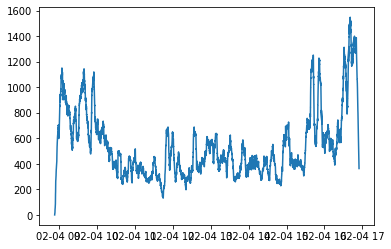

In [56]:
plt.plot(time, pd.DataFrame(np.arange(time.shape[0]), index=time.reshape(-1)).rolling('5min').count().values)
plt.show()

### Order book matrices

For the same ```selected_range``` as in case of tradebook, let's see what the data of order book matrices looks like. I'll describe it for you: in rows you see descending order of prices. Top 5 rows are **best ask** prices, volumes and counts. They are followed by bottom 5 rows that represents 5 best **best bid** prices. First column of every matrix is image of order book for the same timestamp. So we can say that on the moment represented by the first column best prices were created by:
* 7 investors wanting to sell 28 pieces of analyzed instrument for ```1940.0```, while
* 4 investor wanting to buy 14 pieces of analyzed instrument for ```1939.0```

Wait a second! That should enable to answer one of our questions asked above! 

*Please just accept that tradebook index is shifted by 3 rows. It's due to the fact that orderbook change that transaction makes is recorder before the transaction itself. It is specific to the particular data API I'm using and is most probably different elsewhere. It's also not a subject of this blog.*

The transaction we're matching with change of the order book from column 1 to column 2 saw is ```[1940.    2.    2.]```. So market order *had to* come from the bid side! Maybe it's buying pressure? 
We also see that the count of orders at first ask decreased by 1, while count of transactions is 2. That *must've* been two investors performing market orders.

Additionally, analyzed chunk of order and trade books says that there is some *pressure* from bid side (additional volume of 10 on the last level of orderbook in the first column), then there are decreases in ask side (one is most probably another transaction initiated by bid side and the second is one investor changing or cancelling their order of 10)

In [76]:
print('price\n', price_matrix[:,:,selected_range],'\n', '\n','volume\n', volume_matrix[:,:,selected_range],'\n', '\n','count\n', count_matrix[:,:,selected_range],'\n', '\n')
print('volume diff \n',np.diff(volume_matrix[:,:,selected_range],axis=2),'\n', '\n','count diff \n', np.diff(count_matrix[:,:,selected_range],axis=2))

price
 [[[1944. 1944. 1944. 1944. 1944. 1944. 1944. 1944. 1944. 1944.]
  [1943. 1943. 1943. 1943. 1943. 1943. 1943. 1943. 1943. 1943.]
  [1942. 1942. 1942. 1942. 1942. 1942. 1942. 1942. 1942. 1942.]
  [1941. 1941. 1941. 1941. 1941. 1941. 1941. 1941. 1941. 1941.]
  [1940. 1940. 1940. 1940. 1940. 1940. 1940. 1940. 1940. 1940.]
  [1939. 1939. 1939. 1939. 1939. 1939. 1939. 1939. 1939. 1939.]
  [1938. 1938. 1938. 1938. 1938. 1938. 1938. 1938. 1938. 1938.]
  [1937. 1937. 1937. 1937. 1937. 1937. 1937. 1937. 1937. 1937.]
  [1936. 1936. 1936. 1936. 1936. 1936. 1936. 1936. 1936. 1936.]
  [1935. 1935. 1935. 1935. 1935. 1935. 1935. 1935. 1935. 1935.]]] 
 
 volume
 [[[ 48.  48.  48.  48.  48.  48.  48.  48.  48.  48.]
  [ 42.  42.  42.  42.  42.  32.  32.  32.  32.  32.]
  [ 18.  18.  18.  18.  18.  18.  18.  18.  18.  18.]
  [ 36.  36.  36.  36.  36.  36.  36.  36.  36.  36.]
  [ 28.  26.  26.  26.  26.  15.  15.  15.  15.  15.]
  [ 14.  14.  14.  14.  14.  14.  14.  14.  14.  14.]
  [ 23.  23.  2

## The plot instead of summary

That would be all for the first post. I hope this post made you at least a bit curious. 

Just to finish with a plot - let's see how the price behaved few minutes after analyzed chunk, say 1000 timestamps later. 

But before let's introduce wide-spread concept of ```midprice``` that will come handy later (due to the fact that transactions don't happen on every event).

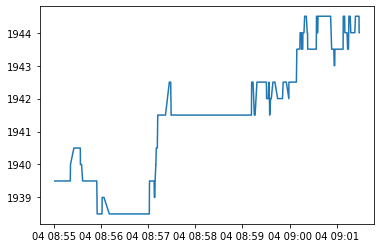

In [85]:
midprice=((price_matrix[:,4,:] + price_matrix[:,5,:])/2).reshape(-1)
future = 1000
plt.plot(time[selected_range[-1]:selected_range[-1]+future], midprice[selected_range[-1]:selected_range[-1]+future])